# 03 - Single-layer NN per Ticker

This notebook trains a single-layer feedforward neural network for each ticker in each sector.

Training AAPL...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


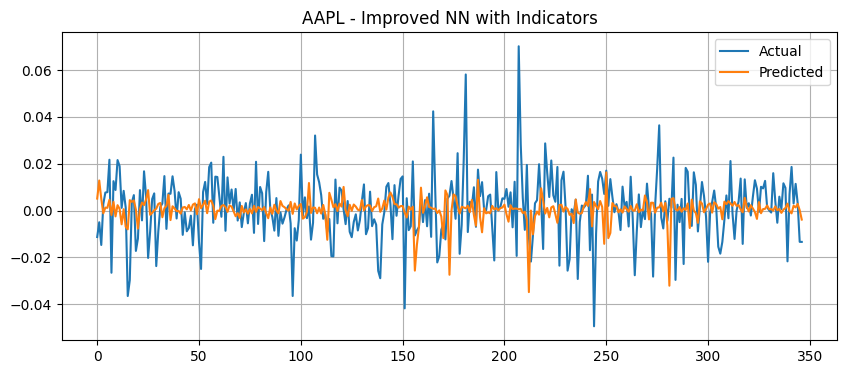

Training MSFT...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


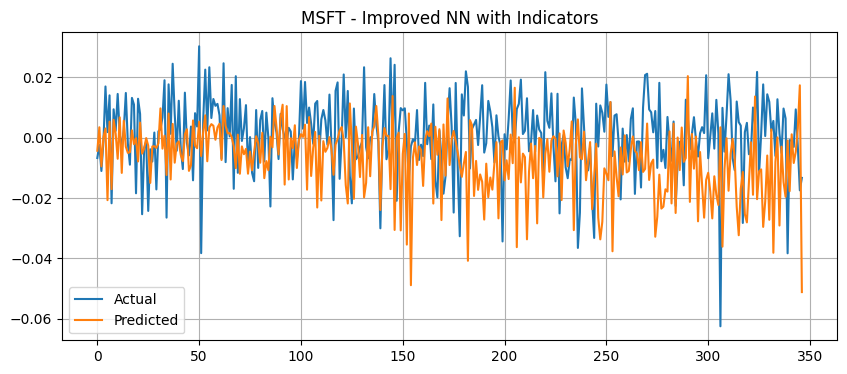

Training JPM...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


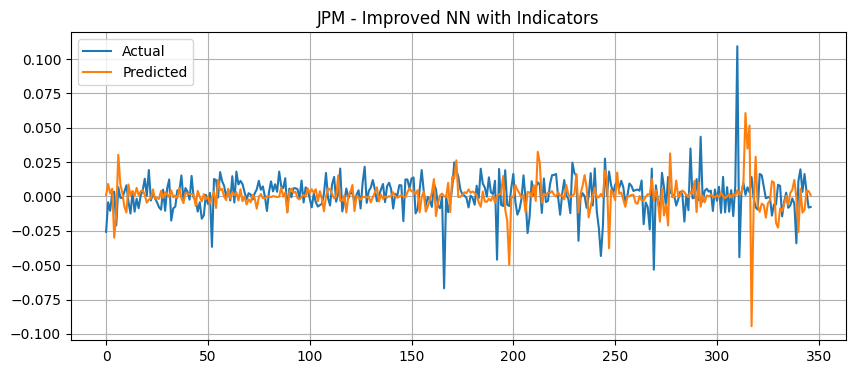

Training BAC...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


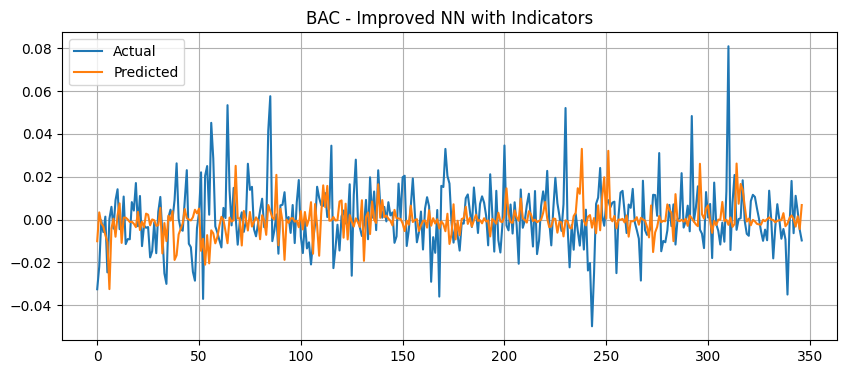

Training XOM...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


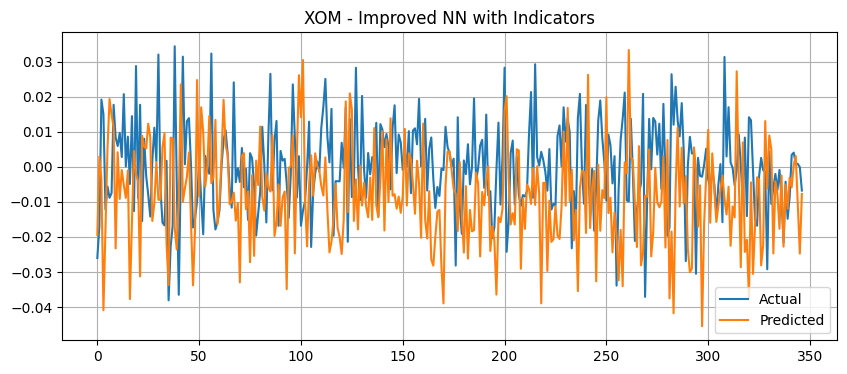

Training CVX...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


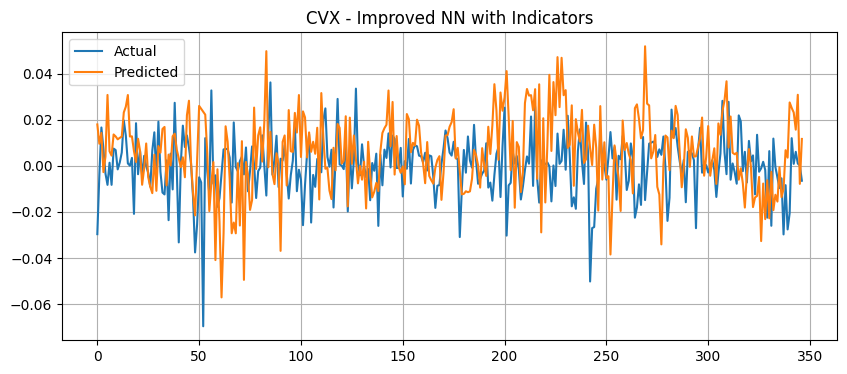

AAPL: MSE = 0.000204, R² = -0.1045
MSFT: MSE = 0.000366, R² = -1.3075
JPM: MSE = 0.000291, R² = -0.6041
BAC: MSE = 0.000278, R² = -0.2581
XOM: MSE = 0.000427, R² = -1.6212
CVX: MSE = 0.000447, R² = -1.7279


In [21]:
import sys
sys.path.append('..')  # Add parent directory for utils module

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from utils.preprocessing import prepare_data
from utils.evaluation import plot_predictions, compute_metrics
import os

tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'XOM', 'CVX']
results = {}

for ticker in tickers:
    print(f"Training {ticker}...")
    df = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # === Add indicators ===
    df['Return'] = df['Close'].pct_change()
    for i in range(1, 6):
        df[f'Lag_{i}'] = df['Return'].shift(i)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # === Define target: 3-day forward log return ===
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['LogReturn'].shift(-3)

    # Drop NaNs created by indicators and target
    df = df.dropna()

    # === Select top 10 correlated features ===
    correlations = df.corr()['Target'].abs().sort_values(ascending=False)
    top_features = correlations[1:11].index.tolist()  # exclude 'Target' itself
    X = df[top_features]
    y = df['Target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === Build improved model ===
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, verbose=0, callbacks=[early_stop])

    # Save model
    os.makedirs('../models/saved_model', exist_ok=True)
    model.save(f'../models/saved_model/{ticker}_improved_nn.h5')

    # Predict and evaluate
    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[ticker] = (mse, r2)

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{ticker} - Improved NN with Indicators")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Print summary ===
for ticker, (mse, r2) in results.items():
    print(f"{ticker}: MSE = {mse:.6f}, R² = {r2:.4f}")